Notebook to investigate a bug in Triton indexing - found when using indexing to do a transposed load.

 - Writing a kernel to just transpose a matrix didn't reproduce the issue - now trying a mat mul kernel with a transposed argument. 

In [1]:
M = 1024
N = 2048 * 2
K = 2048

Mp = 64
Np = 128
Kp = 32

In [2]:
import triton
import triton.language as tl
import torch


@triton.jit
def mmt_kernel(A_ptr, BT_ptr, out_ptr, M: tl.constexpr, N: tl.constexpr,
               K: tl.constexpr, Mp: tl.constexpr, Np: tl.constexpr,
               Kp: tl.constexpr):
    """
    Matrix multiplication kernel where the second argument is (pre-)transposed.

    Inputs
    ------
    A : (M, K)
    B : (K, N) -> Bt : (N, K)

    Ouput
    -----
    out : (M, N) - A @ B
    """

    M_idxs = tl.arange(0, Mp)
    N_idxs = tl.arange(0, Np)

    acc = tl.zeros((Mp, Np), dtype=tl.float32)

    for k in range(0, tl.cdiv(K, Kp)):

        K_idxs = tl.arange(0, Kp) + k * Kp

        A_blk_idxs = M_idxs[:, None] * K + K_idxs[None, :]
        A_blk = tl.load(A_ptr + A_blk_idxs)

        BT_blk_idxs = N_idxs[None, :] * K + K_idxs[:, None]
        # Note: BT is transposed by the indexing scheme - we are therefore effectively
        # loading the untransposed B matrix.
        tl.device_print("BT_blk_idxs: ", BT_blk_idxs)
        B_blk = tl.load(BT_ptr + BT_blk_idxs)

        acc += tl.dot(A_blk, B_blk)

    out_idxs = M_idxs[:, None] * N + N_idxs[None, :]
    tl.store(out_ptr + out_idxs, acc)


def mmt_dispatch(A, BT):
    M, K = A.shape
    N, _ = BT.shape

    out = torch.empty((M, N), dtype=torch.float32, device=A.device)

    mmt_kernel[(1, )](A, BT, out, M, N, K, Mp, Np, Kp)

    return out

In [3]:
A = torch.randn((M, K), dtype=torch.float32, device='cuda')
B = torch.randn((K, N), dtype=torch.float32, device='cuda')
BT = B.T.contiguous()

torch_out = A @ B
torch_out_blk = torch_out[:Mp, :Np]

In [4]:
out = mmt_dispatch(A, BT)
out_blk = out[:Mp, :Np]

In [5]:
%load_ext autoreload
%autoreload 2

BT_blk_idxs: 4096, 12288, 20480, 28672, 36864, 45056, 53248, 61440, 69632, 77824, 86016, 94208, 102400, 110592, 118784, 126976, 135168, 143360, 151552, 159744, 167936, 176128, 184320, 192512, 200704, 208896, 217088, 225280, 233472, 241664, 249856, 258048
BT_blk_idxs: 4097, 12289, 20481, 28673, 36865, 45057, 53249, 61441, 69633, 77825, 86017, 94209, 102401, 110593, 118785, 126977, 135169, 143361, 151553, 159745, 167937, 176129, 184321, 192513, 200705, 208897, 217089, 225281, 233473, 241665, 249857, 258049
BT_blk_idxs: 4098, 12290, 20482, 28674, 36866, 45058, 53250, 61442, 69634, 77826, 86018, 94210, 102402, 110594, 118786, 126978, 135170, 143362, 151554, 159746, 167938, 176130, 184322, 192514, 200706, 208898, 217090, 225282, 233474, 241666, 249858, 258050
BT_blk_idxs: 4099, 12291, 20483, 28675, 36867, 45059, 53251, 61443, 69635, 77827, 86019, 94211, 102403, 110595, 118787, 126979, 135171, 143363, 151555, 159747, 167939, 176131, 184323, 192515, 200707, 208899, 217091, 225283, 233475, 241


BT_blk_idxs: 888, 9080, 17272, 25464, 33656, 41848, 50040, 58232, 66424, 74616, 82808, 91000, 99192, 107384, 115576, 123768, 131960, 140152, 148344, 156536, 164728, 172920, 181112, 189304, 197496, 205688, 213880, 222072, 230264, 238456, 246648, 254840
BT_blk_idxs: 889, 9081, 17273, 25465, 33657, 41849, 50041, 58233, 66425, 74617, 82809, 91001, 99193, 107385, 115577, 123769, 131961, 140153, 148345, 156537, 164729, 172921, 181113, 189305, 197497, 205689, 213881, 222073, 230265, 238457, 246649, 254841
BT_blk_idxs: 890, 9082, 17274, 25466, 33658, 41850, 50042, 58234, 66426, 74618, 82810, 91002, 99194, 107386, 115578, 123770, 131962, 140154, 148346, 156538, 164730, 172922, 181114, 189306, 197498, 205690, 213882, 222074, 230266, 238458, 246650, 254842
BT_blk_idxs: 891, 9083, 17275, 25467, 33659, 41851, 50043, 58235, 66427, 74619, 82811, 91003, 99195, 107387, 115579, 123771, 131963, 140155, 148347, 156539, 164731, 172923, 181115, 189307, 197499, 205691, 213883, 222075, 230267, 238459, 246651

In [8]:
from conch import TensorComparison

In [11]:
TensorComparison(torch_out_blk, out_blk).describe()

,0
shape,"(64, 128)"
mad,0.131882
rel_mad,0.004267
row_max_rel_err,0.000007
col_max_rel_err,0.000014


In [ ]:
from conch import mad

BT_blk_idxs: 0, 8192, 16384, 24576, 32768, 40960, 49152, 57344, 65536, 73728, 81920, 90112, 98304, 106496, 114688, 122880, 131072, 139264, 147456, 155648, 163840, 172032, 180224, 188416, 196608, 204800, 212992, 221184, 229376, 237568, 245760, 253952
BT_blk_idxs: 1, 8193, 16385, 24577, 32769, 40961, 49153, 57345, 65537, 73729, 81921, 90113, 98305, 106497, 114689, 122881, 131073, 139265, 147457, 155649, 163841, 172033, 180225, 188417, 196609, 204801, 212993, 221185, 229377, 237569, 245761, 253953
BT_blk_idxs: 2, 8194, 16386, 24578, 32770, 40962, 49154, 57346, 65538, 73730, 81922, 90114, 98306, 106498, 114690, 122882, 131074, 139266, 147458, 155650, 163842, 172034, 180226, 188418, 196610, 204802, 212994, 221186, 229378, 237570, 245762, 253954
BT_blk_idxs: 3, 8195, 16387, 24579, 32771, 40963, 49155, 57347, 65539, 73731, 81923, 90115, 98307, 106499, 114691, 122883, 131075, 139267, 147459, 155651, 163843, 172035, 180227, 188419, 196611, 204803, 212995, 221187, 229379, 237571, 245763, 253955


In [ ]:
mad(torch_out_blk, out_blk)

0.13981628

In [ ]:
diff = (torch_out_blk - out_blk).abs()

In [ ]:
(diff / torch_out_blk).max()

tensor(0.6304, device='cuda:0')

In [ ]:
mad(torch_out_blk, out_blk) / torch_out_blk.abs().median()

tensor(0.0045, device='cuda:0')

In [ ]:
import matplotlib.pyplot as plt

(array([  3.,   2.,   4.,   4.,  11.,  13.,  28.,  59.,  58., 101., 130.,
        186., 247., 318., 419., 458., 513., 620., 618., 609., 614., 603.,
        542., 448., 376., 318., 253., 207., 140., 113.,  73.,  40.,  27.,
         18.,  12.,   3.,   2.,   0.,   0.,   2.]),
 array([-0.13354492, -0.12671089, -0.11987686, -0.11304283, -0.1062088 ,
        -0.09937477, -0.09254074, -0.08570671, -0.07887268, -0.07203865,
        -0.06520462, -0.05837059, -0.05153656, -0.04470253, -0.0378685 ,
        -0.03103447, -0.02420044, -0.01736641, -0.01053238, -0.00369835,
         0.00313568,  0.00996971,  0.01680374,  0.02363777,  0.0304718 ,
         0.03730583,  0.04413986,  0.05097389,  0.05780792,  0.06464195,
         0.07147598,  0.07831001,  0.08514404,  0.09197807,  0.0988121 ,
         0.10564613,  0.11248016,  0.11931419,  0.12614822,  0.13298225,
         0.13981628]),
 <BarContainer object of 40 artists>)

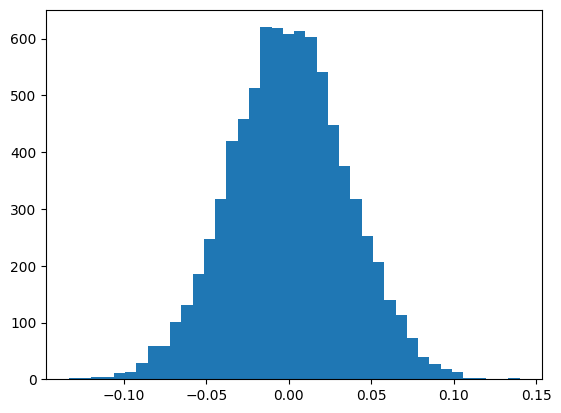

In [ ]:
plt.hist((torch_out_blk - out_blk).ravel().cpu().numpy(), bins = 40)

In [ ]:
import triton
import triton.language as tl
import torch

@triton.jit
def kernel(Mat_ptr, out_ptr, M: tl.constexpr, N: tl.constexpr, Mp: tl.constexpr, Np: tl.constexpr):
    """
    Kernel which transposes `Mat`.

    Inputs
    ------
    Mat : (M, N)

    Outputs
    -------
    out : (N, M) - Mat.T
    
    """

    M_idxs = tl.arange(0, Mp)
    N_idxs = tl.arange(0, Np)

    blk_trans_idxs = N_idxs[None, :] * M + M_idxs[:, None] # (M', N')
    Mat_blk_trans = tl.load(Mat_ptr + blk_trans_idxs) # (M', N')
    # tl.device_print("blk_trans_idxs: ", blk_trans_idxs)

    out_idxs = N_idxs[None, :] * M + M_idxs[:, None]
    tl.store(out_ptr + out_idxs, Mat_blk_trans)

def dispatch(Mat):

    M, N = Mat.shape

    out = torch.zeros_like(Mat.T)

    kernel[(1,)](Mat, out, M, N, Mp = 64, Np = 128)

    return out

In [ ]:
M = 1024
N = 2048

Mp = 64
Np = 128

In [ ]:
Mat = torch.arange(M * N).reshape(M, N).cuda()
Mat

tensor([[      0,       1,       2,  ...,    2045,    2046,    2047],
        [   2048,    2049,    2050,  ...,    4093,    4094,    4095],
        [   4096,    4097,    4098,  ...,    6141,    6142,    6143],
        ...,
        [2091008, 2091009, 2091010,  ..., 2093053, 2093054, 2093055],
        [2093056, 2093057, 2093058,  ..., 2095101, 2095102, 2095103],
        [2095104, 2095105, 2095106,  ..., 2097149, 2097150, 2097151]],
       device='cuda:0')

In [ ]:
M_idxs = torch.arange(0, Mp)
N_idxs = torch.arange(0, Np)

In [ ]:
blk_trans_idxs = N_idxs[None, :] * M + M_idxs[:, None]

In [ ]:
out_idxs = N_idxs[:, None] * M + M_idxs[None, :]
out_idxs.shape

torch.Size([128, 64])

In [ ]:
blk_trans_idxs

tensor([[     0,   1024,   2048,  ..., 128000, 129024, 130048],
        [     1,   1025,   2049,  ..., 128001, 129025, 130049],
        [     2,   1026,   2050,  ..., 128002, 129026, 130050],
        ...,
        [    61,   1085,   2109,  ..., 128061, 129085, 130109],
        [    62,   1086,   2110,  ..., 128062, 129086, 130110],
        [    63,   1087,   2111,  ..., 128063, 129087, 130111]])

In [ ]:
Mat.ravel()[blk_trans_idxs].shape

torch.Size([64, 128])

In [ ]:
Mat

tensor([[      0,       1,       2,  ...,    2045,    2046,    2047],
        [   2048,    2049,    2050,  ...,    4093,    4094,    4095],
        [   4096,    4097,    4098,  ...,    6141,    6142,    6143],
        ...,
        [2091008, 2091009, 2091010,  ..., 2093053, 2093054, 2093055],
        [2093056, 2093057, 2093058,  ..., 2095101, 2095102, 2095103],
        [2095104, 2095105, 2095106,  ..., 2097149, 2097150, 2097151]],
       device='cuda:0')

In [ ]:
dispatch(Mat)[0][:50]

tensor([     0,   2048,   4096,   6144,   8192,  10240,  12288,  14336,  16384,
         18432,  20480,  22528,  24576,  26624,  28672,  30720,  32768,  34816,
         36864,  38912,  40960,  43008,  45056,  47104,  49152,  51200,  53248,
         55296,  57344,  59392,  61440,  63488,  65536,  67584,  69632,  71680,
         73728,  75776,  77824,  79872,  81920,  83968,  86016,  88064,  90112,
         92160,  94208,  96256,  98304, 100352], device='cuda:0')